In [1]:
from geocat.comp.interpolation import interp_hybrid_to_pressure
import xarray as xr
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
import netCDF4 as nc    
import pandas as pd
import Ngl
import cartopy.crs as ccrs
import cftime
from metpy.units import units
from tqdm import tqdm
from Ngl import vinth2p
import sys
import subprocess

In [2]:
path = "/glade/derecho/scratch/awikner/PLASIM/data/2000_year_sims_new/sim0/tas/" #1000_gaussian.nc
# open dataset
ds = xr.open_dataset(path + "1000_gaussian.nc")
ds

/glade/u/apps/opt/conda/envs/npl/lib/python3.11/site-packages/xarray/coding/times.py:832: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/glade/u/apps/opt/conda/envs/npl/lib/python3.11/site-packages/xarray/core/indexing.py:560: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  array = array.get_duck_array()


<xarray.Dataset>
Dimensions:  (lon: 128, lat: 64, time: 1460)
Coordinates:
  * lon      (lon) float64 0.0 2.812 5.625 8.438 ... 348.8 351.6 354.4 357.2
  * lat      (lat) float64 87.86 85.1 82.31 79.53 ... -79.53 -82.31 -85.1 -87.86
  * time     (time) object 1000-01-01 00:00:00 ... 1000-12-31 18:00:00
Data variables:
    tas      (time, lat, lon) float32 ...

In [33]:
ds_daily = ds.resample(time='D').mean()
ds_daily

<xarray.Dataset>
Dimensions:  (time: 365, lat: 64, lon: 128)
Coordinates:
  * lon      (lon) float64 0.0 2.812 5.625 8.438 ... 348.8 351.6 354.4 357.2
  * lat      (lat) float64 87.86 85.1 82.31 79.53 ... -79.53 -82.31 -85.1 -87.86
  * time     (time) object 1000-01-01 00:00:00 ... 1000-12-31 00:00:00
Data variables:
    tas      (time, lat, lon) float32 224.2 224.2 224.2 ... 254.3 254.1 253.9

In [35]:
# make a 3x3 window over Chicago 41.881832, -87.623177.
spatial_window_size = 2
temporal_window_size = 7
lat = 41.881832
# for longitudes take the value modulo 360
lon = -87.623177
lon = lon % 360
# get the index of the lat and lon
lat_idx = np.abs(ds.lat.values - lat).argmin()
lon_idx = np.abs(ds.lon.values - lon).argmin()
# get the window
window = ds_daily.isel(lat=slice(lat_idx-spatial_window_size, lat_idx+spatial_window_size), 
                       lon=slice(lon_idx-spatial_window_size, lon_idx+spatial_window_size))
window

<xarray.Dataset>
Dimensions:  (time: 365, lat: 4, lon: 4)
Coordinates:
  * lon      (lon) float64 267.2 270.0 272.8 275.6
  * lat      (lat) float64 48.84 46.04 43.25 40.46
  * time     (time) object 1000-01-01 00:00:00 ... 1000-12-31 00:00:00
Data variables:
    tas      (time, lat, lon) float32 254.6 252.4 252.7 ... 272.7 274.5 274.5

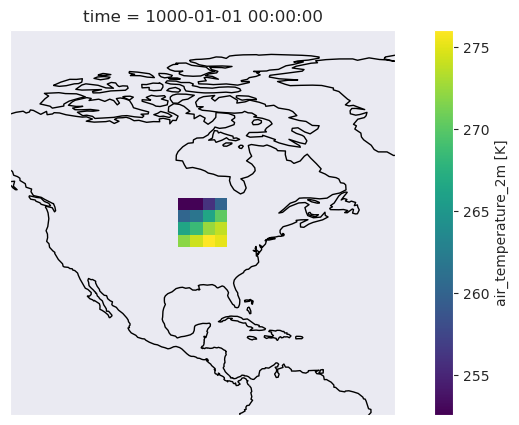

In [27]:
# plot the window for the first time step on the whole map using cartopy
fig = plt.figure(figsize=(10, 5))
ax = plt.axes(projection=ccrs.PlateCarree())
window.isel(time=0).tas.plot(ax=ax, transform=ccrs.PlateCarree())
window_plot = 40
ax.set_extent([window.lon.min()-window_plot, window.lon.max()+window_plot, window.lat.min()-window_plot, window.lat.max()+window_plot])
ax.coastlines()
plt.show()

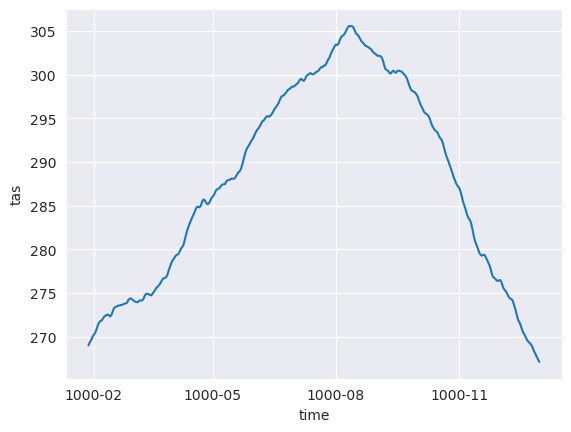

In [38]:
spatial_window_size = 2
temporal_window_size = 7
# Select lat and lon of Chicago
lat = 41.881832
# for longitudes take the value modulo 360
lon = -87.623177 % 360
# get the index of the lat and lon
lat_idx = np.abs(ds.lat.values - lat).argmin()
lon_idx = np.abs(ds.lon.values - lon).argmin()

# compute on observable A being the average temperature in the window over the last the temporal_window_size days
A = ds_daily.isel(lat=slice(lat_idx-spatial_window_size, lat_idx+spatial_window_size), 
                       lon=slice(lon_idx-spatial_window_size, lon_idx+spatial_window_size)).tas.mean(dim=['lat', 'lon']).rolling(time=temporal_window_size*4).mean().dropna('time')
A.plot()

In [4]:
def compute_A(ds, lat, lon, spatial_window_size, temporal_window_size, reduce='mean'):
    # for longitudes take the value modulo 360
    if lon < 0:
        lon = lon % 360
    # get the index of the lat and lon
    lat_idx = np.abs(ds.lat.values - lat).argmin()
    lon_idx = np.abs(ds.lon.values - lon).argmin()

    # compute on observable A being the average temperature in the window over the last the temporal_window_size days
    A = ds.isel(lat=slice(lat_idx-spatial_window_size, lat_idx+spatial_window_size), 
                           lon=slice(lon_idx-spatial_window_size, lon_idx+spatial_window_size))
    if reduce == 'mean':
        A = A.resample(time='D').mean()
    elif reduce == 'max':
        A = A.resample(time='D').max()
    elif reduce == 'min':
        A = A.resample(time='D').min()
    else:
        raise ValueError("reduce must be either 'mean', 'max' or 'min'")
    A = A.tas.mean(dim=['lat', 'lon']).rolling(time=temporal_window_size*4).mean().dropna('time')
    return A

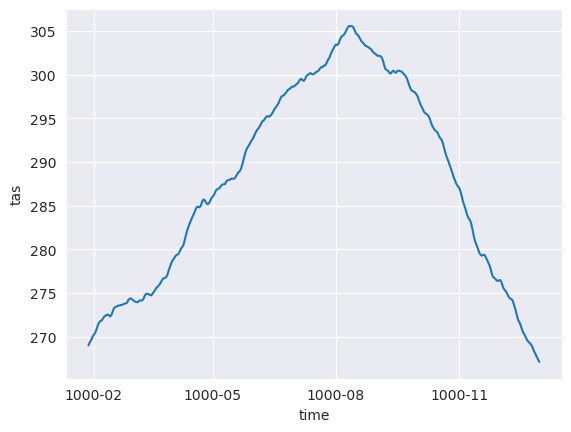

In [63]:
A = compute_A(ds, lat, lon, spatial_window_size, temporal_window_size)
A.plot()

In [52]:
A

<xarray.DataArray 'tas' (time: 338)>
array([268.99643, 269.33716, 269.5841 , 269.95697, 270.19705, 270.43234,
       270.81876, 271.3033 , 271.60742, 271.80405, 271.84686, 272.1108 ,
       272.3338 , 272.40833, 272.51022, 272.5103 , 272.3071 , 272.41766,
       272.832  , 273.2353 , 273.37878, 273.45792, 273.52606, 273.5731 ,
       273.61926, 273.6291 , 273.7092 , 273.78354, 273.80453, 273.90933,
       274.2527 , 274.35974, 274.3481 , 274.2237 , 274.09427, 273.99258,
       273.94305, 273.95325, 274.12836, 274.13754, 274.12732, 274.29474,
       274.64178, 274.8759 , 274.90112, 274.84503, 274.77118, 274.72467,
       274.9399 , 275.1679 , 275.37805, 275.63275, 275.75867, 275.9332 ,
       276.18713, 276.4701 , 276.65918, 276.7331 , 276.77762, 277.09396,
       277.60117, 278.01132, 278.44427, 278.7554 , 278.96786, 279.2199 ,
       279.3593 , 279.4319 , 279.665  , 280.03296, 280.2448 , 280.49026,
       281.11163, 281.7218 , 282.2645 , 282.70135, 283.06763, 283.45782,
       283.8336 , 284.12616, 284.54016, 284.84158, 284.8606 , 284.8121 ,
       285.00537, 285.46332, 285.71133, 285.61768, 285.3147 , 285.17877,
       285.26587, 285.54355, 285.88925, 286.05734, 286.28537, 286.66064,
       286.8731 , 286.93515, 287.01923, 287.24396, 287.41696, 287.45297,
       287.46408, 287.7637 , 287.91293, 287.94385, 287.998  , 288.10422,
       288.08517, 288.0906 , 288.27472, 288.57315, 288.79364, 288.92908,
       289.23383, 289.72498, 290.32535, 290.93542, 291.41464, 291.7109 ,
...
       300.634  , 300.5322 , 300.45004, 300.1938 , 300.1424 , 300.3658 ,
       300.47867, 300.27512, 300.2577 , 300.44888, 300.46884, 300.41943,
       300.35855, 300.20233, 300.02533, 299.8596 , 299.57492, 299.13464,
       298.6693 , 298.31247, 298.14542, 298.07687, 297.96848, 297.785  ,
       297.52515, 297.06934, 296.656  , 296.35165, 296.02628, 295.7076 ,
       295.5564 , 295.45233, 295.30518, 294.9834 , 294.52405, 294.1341 ,
       293.86444, 293.63022, 293.52313, 293.33197, 292.9749 , 292.7176 ,
       292.53174, 292.09183, 291.52203, 290.92563, 290.4795 , 290.09778,
       289.64792, 289.23178, 288.74432, 288.24677, 287.8472 , 287.4815 ,
       287.24008, 287.0661 , 286.65793, 286.0321 , 285.44968, 285.00024,
       284.51764, 283.9515 , 283.58112, 283.38818, 282.99353, 282.3023 ,
       281.519  , 280.8942 , 280.49908, 280.1303 , 279.63824, 279.39365,
       279.2688 , 279.3618 , 279.3653 , 279.08514, 278.75616, 278.42685,
       278.08313, 277.48932, 276.96066, 276.74982, 276.64703, 276.43442,
       276.3586 , 276.47028, 276.4541 , 276.0889 , 275.6009 , 275.35416,
       275.18018, 274.89758, 274.56808, 274.37262, 274.30066, 274.15372,
       273.64456, 273.19104, 272.56613, 271.95374, 271.65732, 271.3121 ,
       270.81863, 270.44592, 270.20978, 269.89124, 269.54492, 269.41357,
       269.20944, 269.0503 , 268.7381 , 268.33435, 268.03268, 267.693  ,
       267.39514, 267.09885], dtype=float32)
Coordinates:
  * time     (time) object 1000-01-28 00:00:00 ... 1000-12-31 00:00:00

In [3]:
# Combine all files in path 
# select var 
var = 'tas'
sim_number = 0
path = f"/glade/derecho/scratch/awikner/PLASIM/data/2000_year_sims_new/sim{sim_number}/{var}/"
# select lat, lon and window size
spatial_window_size = 2
temporal_window_size = 7
# Select lat and lon of Chicago
lat = 41.881832
lon = -87.623177 % 360 # for longitudes take the value modulo 360


files = [f for f in os.listdir(path) if f.endswith('gaussian.nc')]
files = files

# disable the printing of the warning
import warnings
warnings.filterwarnings('ignore')

from src.utils import compute_A
# combine all files using compute_A as a preprocessing function 
A = xr.open_mfdataset([path+file for file in files], preprocess=lambda ds: compute_A(ds, lat, lon, spatial_window_size, temporal_window_size), combine='nested',
                       concat_dim='time', parallel=True)

# # combine all files using the compute_A as a preprocessing step #, add tqdm to see the progress
# A = xr.concat([compute_A(xr.open_dataset(path + f), lat, lon, spatial_window_size, temporal_window_size) for f in tqdm(files)], dim='time')

In [ ]:
A.plot()

In [ ]:
A.to_netcdf(f'A.nc')